In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step

In [2]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# RNN

In [50]:
num_classes = 14
batchsize=15
# specs
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
learningRate = 0.005


In [51]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion, epoch):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    batch_out = Parallel(n_jobs = -1)(delayed(train_batch)(batchseq, model) for batchseq in sequence)
    #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def train_batch(batch_seqs, model):
    hidden = model.initHidden()
    for i in range(len(batch_seqs)):
            output, hidden = model.forward(batch_seqs[i], hidden)
    return output
    
def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion, epoch)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion, epoch)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

# def run_sim(i):
#     print('########## rep ', i, '##########')
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
#     loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
#     losses = loss1+loss2
#     accs = np.vstack([acc1,acc2])
#     return losses, accs

def run_sim(i):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])

    return losses, accs, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=8)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[4*j+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean().sort_values(by = 'acc', ascending=False)
                
    return df 

# Load Data

In [52]:
os.listdir('../sequences/pretraining/')

['type1',
 '.DS_Store',
 'type2_12',
 'type2_48',
 'type5',
 'type3',
 'type4',
 'type2_3']

In [53]:
pretrainpath = '../sequences/pretraining/'

with open(pretrainpath+'type2_3', 'rb') as f:
    type2_3 = pickle.load(f)
with open(pretrainpath+'type2_12', 'rb') as f:
    type2_12 = pickle.load(f)
with open(pretrainpath+'type2_48', 'rb') as f:
    type2_48 = pickle.load(f)

# Load Training and Test data
trianpath = '../sequences/training/'


#Mset
with open(trianpath + 'Mset', 'rb') as f:
    Mset = pickle.load(f)
with open(trianpath + 'Mcombos', 'rb') as f:
    Mcombos = pickle.load(f)
with open(trianpath + 'Morder', 'rb') as f:
    Morder = pickle.load(f)
with open(trianpath + 'Minit', 'rb') as f:
    Minit = pickle.load(f)

# MC set
with open(trianpath + 'MCset', 'rb') as f:
    MCset = pickle.load(f)
with open(trianpath + 'MCorder', 'rb') as f:
    MCorder = pickle.load(f)
with open(trianpath + 'MCinit', 'rb') as f:
    MCinit = pickle.load(f)
    
# DC set
with open(trianpath + 'DCset', 'rb') as f:
    DCset = pickle.load(f)
with open(trianpath + 'DCorder', 'rb') as f:
    DCorder = pickle.load(f)
with open(trianpath + 'DCinit', 'rb') as f:
    DCinit = pickle.load(f)

# F set
with open(trianpath + 'Fset', 'rb') as f:
    Fset = pickle.load(f)
with open(trianpath + 'Finit', 'rb') as f:
    Finit = pickle.load(f)

# Train/test Sequences

In [54]:
# convert sequences to inputs 

# Pretraining
padtype2_3 = pad_seqs_2step(type2_3)
train_inputs = convert_seq2inputs(padtype2_3, num_classes=num_classes, seq_len=8)
trainT2_3 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtype2_12 = pad_seqs_2step(type2_12)
train_inputs = convert_seq2inputs(padtype2_12, num_classes=num_classes, seq_len=8)
trainT2_12 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtype2_48 = pad_seqs_2step(type2_48)
train_inputs = convert_seq2inputs(padtype2_48, num_classes=num_classes, seq_len=8)
trainT2_48 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Mset
# Mset
train_inputs = convert_seq2inputs(Mset, num_classes=num_classes, seq_len=7)
trainMset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mcombos, num_classes=num_classes, seq_len=7)
testMcombos = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Morder, num_classes=num_classes, seq_len=7)
testMorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Minit, num_classes=num_classes, seq_len=7)
testMinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# MCaset
train_inputs = convert_seq2inputs(MCset, num_classes=num_classes, seq_len=7)
trainMCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCorder, num_classes=num_classes, seq_len=7)
testMCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCinit, num_classes=num_classes, seq_len=7)
testMCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# DCaset
train_inputs = convert_seq2inputs(DCset, num_classes=num_classes, seq_len=7)
trainDCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCorder, num_classes=num_classes, seq_len=7)
testDCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCinit, num_classes=num_classes, seq_len=7)
testDCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# Fset
train_inputs = convert_seq2inputs(Fset, num_classes=num_classes, seq_len=7)
trainFset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Finit, num_classes=num_classes, seq_len=7)
testFinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# P3

In [55]:
num_sims = 40
epochs = 700
learningRate = 0.005

In [56]:
#batch = 15

epochs = 70
num_sims = 1

trainset = [trainFset]
test_sets = [trainFset, testFinit]

t1 = time.time()
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)

# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)


loss: 21073.9 
time:  0.8180973688761394


In [57]:
#batch = 20

epochs = 70
num_sims = 1

trainset = [trainFset]
test_sets = [trainFset, testFinit]

t1 = time.time()
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)

# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)


loss: 21224.8 
time:  0.8148685018221538


In [42]:
# batch = 5

epochs = 70
num_sims = 1

trainset = [trainFset]
test_sets = [trainFset, testFinit]

t1 = time.time()
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)

# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)


loss: 62681.8 
time:  0.9323330839474996


In [34]:
# batch = 1

epochs = 70
num_sims = 1

trainset = [trainFset]
test_sets = [trainFset, testFinit]

t1 = time.time()
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)

# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)



loss: 315408.7 
time:  1.1055270632108052


In [19]:
# batch = 25

epochs = 70
num_sims = 1

trainset = [trainFset]
test_sets = [trainFset, testFinit]

t1 = time.time()
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)

# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)



loss: 12618.1 
time:  0.8806596636772156


In [116]:
#%load_ext line_profiler
%lprun -f Parallel run_sim(1)

/Users/miahannah/opt/anaconda3/lib/python3.8/site-packages/line_profiler/ipython_extension.py:71: UserWarning: Could not extract a code object for the object <class 'joblib.parallel.Parallel'>
  profile = LineProfiler(*funcs)


########## rep  1 ##########
loss: 250.5 
loss: 1114.6 


In [111]:
epochs = 700
num_sims = 1

trainset = [trainT2_3, trainMCset]
test_sets = [trainMCset, testMCinit]

t1 = time.time()
t23FFFres = run_sim(1)
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)



########## rep  1 ##########
loss: 117.0 
loss: 1124.0 
time:  1.476823349793752


In [20]:
########### Mset
trainset = [train2_3, trainMset]
test_sets = [trainMset, trainMtest_combos, trainMtest_order, trainMtest_init]
t1 = time.time()
P3_Mres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P3_Mlosses = np.hstack([P3_Mres[i][0] for i in range(len(P3_Mres))])
P3_Macc_train = np.array([P3_Mres[i][1][:,0] for i in range(len(P3_Mres))]).T
P3_Macc_combos = np.array([P3_Mres[i][1][:,1] for i in range(len(P3_Mres))]).T
P3_Macc_order = np.array([P3_Mres[i][1][:,2] for i in range(len(P3_Mres))]).T
P3_Macc_init = np.array([P3_Mres[i][1][:,3] for i in range(len(P3_Mres))]).T

NameError: name 'train2_3' is not defined

In [29]:
print('train acc final: ',np.mean(P3_Macc_train[-1,:]))
print('combos acc final: ',np.mean(P3_Macc_combos[-1,:]))
print('order acc final: ',np.mean(P3_Macc_order[-1,:]))
print('init acc final: ',np.mean(P3_Macc_init[-1,:]))

train acc final:  0.8875
combos acc final:  0.0375
order acc final:  0.08611764705882352
init acc final:  0.05694444444444444


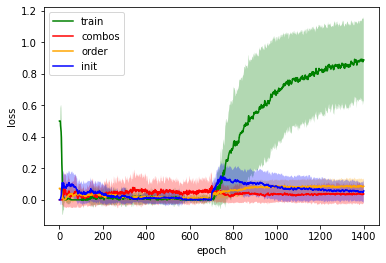

In [12]:
NNplt.plotNN_shifted([P3_Macc_train, P3_Macc_combos, P3_Macc_order, P3_Macc_init],\
                    labels = ['train', 'combos','order','init'],\
                    colors = ['green','red','orange', 'blue'],\
                    shift = 0)

In [13]:
############### MC set
trainset = [P3, trainMCset]
test_sets = [trainMCset, trainMCtest_order, trainMCtest_init]
t1 = time.time()
P3_MCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P3_MClosses = np.hstack([P3_MCres[i][0] for i in range(len(P3_MCres))])
P3_MCacc_train = np.array([P3_MCres[i][1][:,0] for i in range(len(P3_MCres))]).T
P3_MCacc_order = np.array([P3_MCres[i][1][:,1] for i in range(len(P3_MCres))]).T
P3_MCacc_init = np.array([P3_MCres[i][1][:,2] for i in range(len(P3_MCres))]).T


time:  62.07651560306549


In [31]:
print('train acc final: ',np.mean(P3_MCacc_train[-1,:]))
print('order acc final: ',np.mean(P3_MCacc_order[-1,:]))
print('init acc final: ',np.mean(P3_MCacc_init[-1,:]))

train acc final:  0.4791666666666667
order acc final:  0.03402941176470588
init acc final:  0.06508333333333334


In [59]:
NNplt.plotNN_shifted([P3_MCacc_train, P3_MCacc_order, P3_MCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green', 'orange','blue'],\
                    shift = 0)


NameError: name 'P3_MCacc_train' is not defined

In [15]:
############### DC set
trainset = [P3, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
P3_DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P3_DClosses = np.hstack([P3_DCres[i][0] for i in range(len(P3_DCres))])
P3_DCacc_train = np.array([P3_DCres[i][1][:,0] for i in range(len(P3_DCres))]).T
P3_DCacc_order = np.array([P3_DCres[i][1][:,1] for i in range(len(P3_DCres))]).T
P3_DCacc_init = np.array([P3_DCres[i][1][:,2] for i in range(len(P3_DCres))]).T

time:  42.27589831749598


In [32]:
print('train acc final: ',np.mean(P3_DCacc_train[-1,:]))
print('order acc final: ',np.mean(P3_DCacc_order[-1,:]))
print('init acc final: ',np.mean(P3_DCacc_init[-1,:]))

train acc final:  0.38377272727272727
order acc final:  0.04099107142857143
init acc final:  0.0548


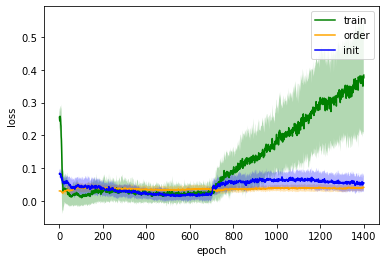

In [16]:
NNplt.plotNN_shifted([P3_DCacc_train, P3_DCacc_order, P3_DCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green', 'orange','blue'],\
                    shift = 0)


In [17]:
############### `F set
trainset = [P3, trainFset]
test_sets = [trainDCset, trainFtest_init]
t1 = time.time()
P3_Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

P3_Flosses = np.hstack([P3_Fres[i][0] for i in range(len(P3_Fres))])
P3_Facc_train = np.array([P3_Fres[i][1][:,0] for i in range(len(P3_Fres))]).T
P3_Facc_test_init = np.array([P3_Fres[i][1][:,1] for i in range(len(P3_Fres))]).T


time:  95.26024456818898


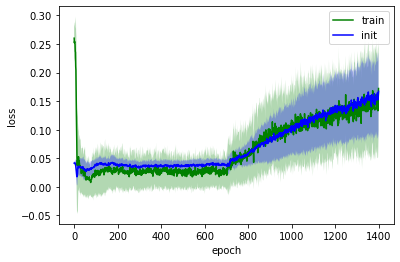

In [18]:
NNplt.plotNN_shifted([P3_Facc_train,P3_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green', 'blue'],\
                    shift = 0)


In [34]:
print('train acc final: ',np.mean(P3_Facc_train[-1,:]))
print('init acc final: ',np.mean(P3_Facc_test_init[-1,:]))

train acc final:  0.17213636363636364
init acc final:  0.16722222222222222


# P12

In [36]:
########### Mset
trainset = [P12, trainMset]
test_sets = [trainMset, trainMtest_combos, trainMtest_order, trainMtest_init]
t1 = time.time()
P12_Mres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P12_Mlosses = np.hstack([P12_Mres[i][0] for i in range(len(P12_Mres))])
P12_Macc_train = np.array([P12_Mres[i][1][:,0] for i in range(len(P12_Mres))]).T
P12_Macc_combos = np.array([P12_Mres[i][1][:,1] for i in range(len(P12_Mres))]).T
P12_Macc_order = np.array([P12_Mres[i][1][:,2] for i in range(len(P12_Mres))]).T
P12_Macc_init = np.array([P12_Mres[i][1][:,3] for i in range(len(P12_Mres))]).T


time:  9.150223350524902


In [38]:
print('train acc final: ',np.mean(P12_Macc_train[-1,:]))
print('combos acc final: ',np.mean(P12_Macc_combos[-1,:]))
print('order acc final: ',np.mean(P12_Macc_order[-1,:]))
print('init acc final: ',np.mean(P12_Macc_init[-1,:]))

train acc final:  0.9541666666666668
combos acc final:  0.024999999999999998
order acc final:  0.060852941176470575
init acc final:  0.04583333333333333


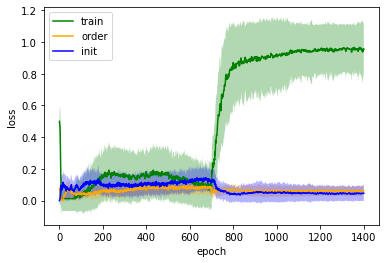

In [39]:
NNplt.plotNN_shifted([P12_Macc_train, P12_Macc_combos, P12_Macc_order, P12_Macc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','red', 'orange', 'blue'],\
                    shift = 0)

In [40]:
############### MC set
trainset = [P12, trainMCset]
test_sets = [trainMCset, trainMCtest_order, trainMCtest_init]
t1 = time.time()
P12_MCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P12_MClosses = np.hstack([P12_MCres[i][0] for i in range(len(P12_MCres))])
P12_MCacc_train = np.array([P12_MCres[i][1][:,0] for i in range(len(P12_MCres))]).T
P12_MCacc_order = np.array([P12_MCres[i][1][:,1] for i in range(len(P12_MCres))]).T
P12_MCacc_init = np.array([P12_MCres[i][1][:,2] for i in range(len(P12_MCres))]).T

time:  39.61298555135727


NameError: name 'res' is not defined

In [46]:
print('train acc final: ',np.mean(P12_MCacc_train[-1,:]))
print('order acc final: ',np.mean(P12_MCacc_order[-1,:]))
print('init acc final: ',np.mean(P12_MCacc_init[-1,:]))

train acc final:  0.5597222222222222
order acc final:  0.04289915966386555
init acc final:  0.0475


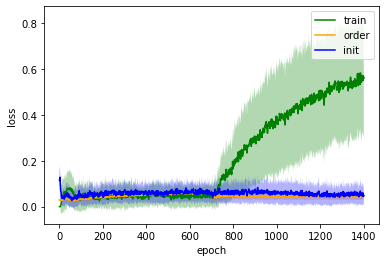

In [47]:
NNplt.plotNN_shifted([P12_MCacc_train, P12_MCacc_order, P12_MCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [48]:
############### DC set
trainset = [P12, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
P12_DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P12_DClosses = np.hstack([P12_DCres[i][0] for i in range(len(P12_DCres))])
P12_DCacc_train = np.array([P12_DCres[i][1][:,0] for i in range(len(P12_DCres))]).T
P12_DCacc_order = np.array([P12_DCres[i][1][:,1] for i in range(len(P12_DCres))]).T
P12_DCacc_init = np.array([P12_DCres[i][1][:,2] for i in range(len(P12_DCres))]).T

time:  53.3467667500178


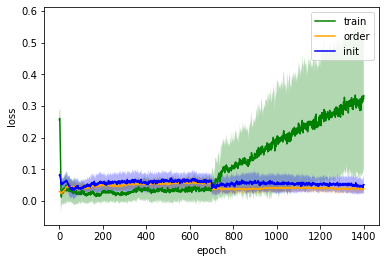

In [49]:
NNplt.plotNN_shifted([P12_DCacc_train, P12_DCacc_order, P12_DCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [50]:
print('train acc final: ',np.mean(P12_DCacc_train[-1,:]))
print('order acc final: ',np.mean(P12_DCacc_order[-1,:]))
print('init acc final: ',np.mean(P12_DCacc_init[-1,:]))

train acc final:  0.3327272727272727
order acc final:  0.03874107142857143
init acc final:  0.051575


In [51]:
############### `F set
trainset = [P12, trainFset]
test_sets = [trainDCset, trainFtest_init]
t1 = time.time()
P12_Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

P12_Flosses = np.hstack([P12_Fres[i][0] for i in range(len(P12_Fres))])
P12_Facc_train = np.array([P12_Fres[i][1][:,0] for i in range(len(P12_Fres))]).T
P12_Facc_test_init = np.array([P12_Fres[i][1][:,1] for i in range(len(P12_Fres))]).T


time:  62.78549435138702


In [54]:
len(P12_Facc_train)

1400

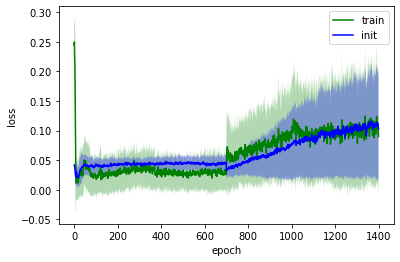

In [52]:
NNplt.plotNN_shifted([P12_Facc_train,P12_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green', 'blue'],\
                    shift = 0)


In [53]:
print('train acc final: ',np.mean(P12_Facc_train[-1,:]))
print('init acc final: ',np.mean(P12_Facc_init[-1,:]))

train acc final:  0.08990909090909091


NameError: name 'P12_Facc_init' is not defined

# P48

In [44]:
############### MC set
trainset = [P48, trainMCset]
test_sets = [trainMCset, trainMCtest_order, trainMCtest_init]
t1 = time.time()
P48_MCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P48_MClosses = np.hstack([P48_MCres[i][0] for i in range(len(res))])
P48_MCacc_train = np.array([P48_MCres[i][1][:,0] for i in range(len(res))]).T
P48_MCacc_order = np.array([P48_MCres[i][1][:,1] for i in range(len(res))]).T
P48_MCacc_init = np.array([P48_MCres[i][1][:,2] for i in range(len(res))]).T

time:  13.762394666671753


In [ ]:
NNplt.plotNN_shifted([P48_MCacc_train, P48_MCacc_order, P48_MCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [33]:
############### DC set
trainset = [P48, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
P48_DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

P48_DClosses = np.hstack([P48_DCres[i][0] for i in range(len(res))])
P48_DCacc_train = np.array([P48_DCres[i][1][:,0] for i in range(len(res))]).T
P48_DCacc_order = np.array([P48_DCres[i][1][:,1] for i in range(len(res))]).T
P48_DCacc_init = np.array([P48_DCres[i][1][:,2] for i in range(len(res))]).T

time:  18.445088064670564


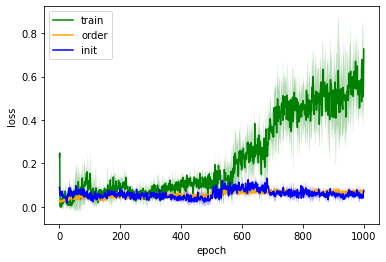

In [34]:
NNplt.plotNN_shifted([P48_DCacc_train, P48_DCacc_order, P48_DCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [35]:
############### `F set
trainset = [P48, trainFset]
test_sets = [trainDCset, trainFtest_init]
t1 = time.time()
P48_Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

P48_Flosses = np.hstack([P48_Fres[i][0] for i in range(len(P48_Fres))])
P48_Facc_train = np.array([P48_Fres[i][1][:,0] for i in range(len(P48_Fres))]).T
P48_Facc_test_init = np.array([P48_Fres[i][1][:,1] for i in range(len(P48_Fres))]).T


time:  32.22433774868647


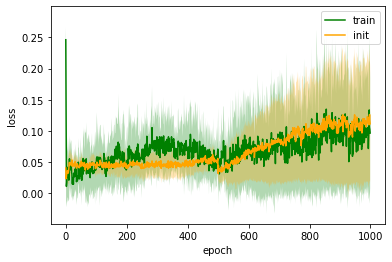

In [36]:
NNplt.plotNN_shifted([P48_Facc_train, P48_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green','blue'],\
                    shift = 0)


In [58]:
p1 = NNplt.plotNN_shifted([P48_Facc_train, P48_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green','blue'],\
                    shift = 0)

NameError: name 'P48_Facc_train' is not defined

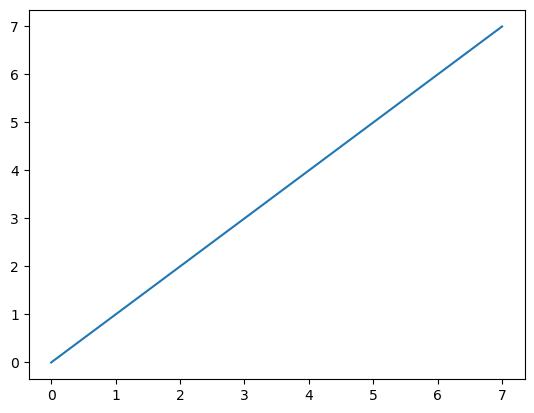

In [62]:
p1 = plt.plot(list(range(8)),list(range(8)))

AttributeError: 'AxesSubplot' object has no attribute 'p1'

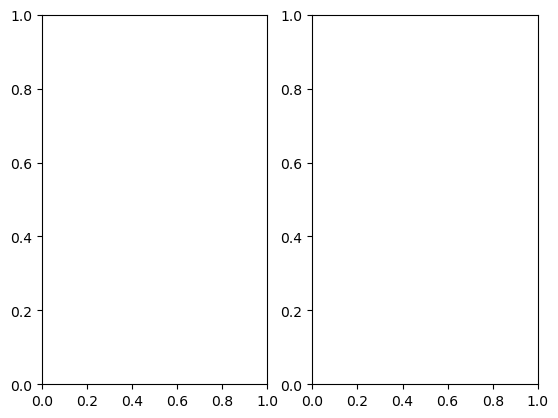

In [66]:
fig, ax = plt.subplots(1, 2)
ax[0].p1
ax[0].p1